# Credmark - Uniswap V3 Liquidity Explorer

- 2022.7.29

In [13]:
from decimal import Decimal
import math

from src.sqrtmath import SqrtPriceMath
from src.v3_liquidity import *

smath = SqrtPriceMath()

In [14]:
%load_ext credmark.cmf.ipython

The credmark.cmf.ipython extension is already loaded. To reload it, use:
  %reload_ext credmark.cmf.ipython


In [15]:
param = {'chain_id': 1,
 'block_number': 15269596,
 'model_loader_path': ['../../credmark-models-py/models'],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context, model_loader = %cmf param

### Load from Ledger or file


In [16]:
load_from_ledger = False

if load_from_ledger:
    pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

    with pool.ledger.events.Flash as q:
        df_flash = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER,limit=5000).to_dataframe()

    with pool.ledger.events.Mint as q:
        df_mint = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        limit=10).to_dataframe()

    with pool.ledger.events.Burn as q:
        df_burn = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        limit=10).to_dataframe()

    with pool.ledger.events.Swap as q:
        df_swap = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        limit=10).to_dataframe()

    df_flash.to_csv('csv/uni_flash.csv', index=False)
    df_mint.to_csv('csv/uni_mint.csv', index=False)
    df_burn.to_csv('csv/uni_burn.csv', index=False)
    df_swap.to_csv('csv/uni_swap.csv', index=False)

    with pool.ledger.events.Mint as q:
        df_mint_min_max = q.select(aggregates=[(q.TICKLOWER.min_(), 'lower_min'),
                                            (q.TICKUPPER.max_(), 'upper_max'),
                                            (q.EVT_BLOCK_NUMBER.min_(), 'block_number_min'),
                                            (q.EVT_BLOCK_NUMBER.max_(), 'block_number_max')]
                                ).to_dataframe()

    with pool.ledger.events.Burn as q:
        df_burn_min_max = q.select(aggregates=[(q.TICKLOWER.min_(), 'lower_min'),
                                            (q.TICKUPPER.max_(), 'upper_max'),
                                            (q.EVT_BLOCK_NUMBER.min_(), 'block_number_min'),
                                            (q.EVT_BLOCK_NUMBER.max_(), 'block_number_max')]
                                ).to_dataframe()    

    df_mint_min_max.to_csv('csv/df_mint_min_max.csv', index=False)
    df_burn_min_max.to_csv('csv/df_burn_min_max.csv', index=False)

In [17]:
if not load_from_ledger:
    df_flash = pd.read_csv('csv/uni_flash.csv')
    df_mint = pd.read_csv('csv/uni_mint.csv')
    df_burn = pd.read_csv('csv/uni_burn.csv')
    df_swap = pd.read_csv('csv/uni_swap.csv')

    df_mint_min_max = pd.read_csv('csv/df_mint_min_max.csv')
    df_burn_min_max = pd.read_csv('csv/df_burn_min_max.csv')

## Transform

In [18]:
df_mint_sel = (df_mint
    [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_owner', 'inp_ticklower', 'inp_tickupper', 'inp_amount', 'inp_amount0', 'inp_amount1']]
)
df_mint_sel

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_ticklower,inp_tickupper,inp_amount,inp_amount0,inp_amount1
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,345073104699360,2995507735,999999999871526500
1,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990,195010,25652705721581,1000000,145737680853531
2,12377266,286,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730,195460,447994594415865,598469729,2599999995846641700
3,12377308,355,0x5f066eb8fefba0d1b491ffb924b708dc24158192a77f...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194660,194990,3508224747038658,3405610348,0
4,12377327,105,0x5184d8d442ac1696e9f7fb89c31db8c1de8ae9c80f3e...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194640,194660,35118767990408024,1549658850,151652526935341120
5,12377429,37,0x112f8d32c821a10d91d333738b7b5f5db8ce19ed7c7d...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,193380,196260,4828391768114933,22181745033,4999999999799242000
6,12377645,294,0xa0ef29c71238e5d91bf4427b242c860e5cfd89d75d2a...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,193380,200310,1092382261109467,15454577376,1282710509619309000
7,12378038,326,0x6e310ed13ea72d30bff67a919754c027cec654a174c8...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194750,194790,1499570648517615,167201379,2790710881979345
8,12378075,156,0x16321f1e501c0411c2d26bfc6c6e40fcaf5ac8f4f6e9...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,-46050,414490,3068914230032,181389532,51921516403623350
9,12378260,211,0x8fc80d2d648112f340b42f1e76c3ce7f52b6c61f10f7...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194720,194840,38466559516912,10000000,1033365407263396


In [19]:
df_burn_sel = (df_burn
    [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_owner', 'inp_ticklower', 'inp_tickupper', 'inp_amount', 'inp_amount0', 'inp_amount1']]
    .assign(inp_amount=lambda x: -x.inp_amount,
            inp_amount0=lambda x: -x.inp_amount0,
            inp_amount1=lambda x: -x.inp_amount1)
)
df_burn_sel

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_ticklower,inp_tickupper,inp_amount,inp_amount0,inp_amount1
0,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-310565794229424,-2588187276,-931484249884373900
1,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,0,0,0
2,12378139,281,0x0071c57b5c72215b9eb61237306078b0d66bc4b7477f...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194750,194790,-1499570648517615,0,-50832403254742610
3,12378381,185,0x65604668f6fdfbccbeb35a21f007bebf6818132da39f...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194660,194990,-3508224747038658,-2196096821,-345697133216421570
4,12378701,400,0x70e43fee246eb5820c625627aecde047c8b3296297ed...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,276320,276330,-2000197335909935,-999999,0
5,12378975,305,0x52aedef3b34b14b0af2f63b205bc61fde5e529aee2d9...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194640,194660,-35118767990408024,0,-591666931208717400
6,12379404,384,0x641cf4b2131515ee408e2b869660627023793f877ccb...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,223340,230270,-96598418924930,-399999999,0
7,12381171,330,0xe59121c20bca00ca943ba2ce7b714e4d0a05aaece498...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730,195460,-447994594415865,-844518248,-2528365289342729000
8,12384559,158,0x26bbb0f5eec5930ab9b5319e4c02a6caeb257ff219e7...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198680,-34146802946959,-339483650,-101110504989477680
9,12384601,25,0x34a244f676e553b5eca4655ab5e3331fb8e2ca27b842...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,193380,196260,-4828391768114933,-18329786827,-6108217281320156000


In [20]:
(df_swap
    [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_recipient', 'inp_liquidity', 'inp_amount0', 'inp_amount1', 'inp_tick', 'inp_sqrtpricex96']]
    .assign(inp_sqrtpricex96_d= df_swap.inp_sqrtpricex96.apply(int))
    .assign(price = lambda x: x.inp_sqrtpricex96_d * x.inp_sqrtpricex96_d / (2 ** 192),
            price_tick = lambda x: (1.0001 ** x.inp_tick).apply(Decimal),
            price_sqrt = lambda x: 1.0001 ** (x.inp_tick / 2) * (2 ** 96))
)

,evt_block_number,evt_index,evt_tx_hash,inp_recipient,inp_liquidity,inp_amount0,inp_amount1,inp_tick,inp_sqrtpricex96,inp_sqrtpricex96_d,price,price_tick,price_sqrt
0,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360,-119744094,35000000000000000,194996,1.358207e+33,1358206768703179042788037967740928,293881747.391735,293863251.161477267742156982421875,1358164026850984271828621602062336.0
1,12377278,240,0x53d4bc1240410e1c7907b8049f2355e226f5fcae8c16...,0xE592427A0AEce92De3Edee1F18E0157C05861564,482501904885801,499756414,-144241064315415170,194645,1.334546e+33,1334545912983135588442782975393792,283731707.552176,283728070.693751037120819091796875,1334537359885312233470678878126080.0
2,12377345,133,0x730978754a9a3db693148ac99b5d807555b2e7c1d664...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,365000000,-103492428467657970,194641,1.334316e+33,1334315597745344143646790837600256,283633783.462463,283614607.8326070308685302734375,1334270492444118574642620142714880.0
3,12377364,353,0x121c9e49d7a44eaa01e50070df2e4d8a95aace62ddfe...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,-176180828,50000000000000000,194643,1.334427e+33,1334426813649531906780496027189248,283681067.481878,283671333.59031963348388671875,1334403919493362931880428123979776.0
4,12377369,133,0x26fd434e17ef8607ba00e09292232ebf45687c95603d...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,-514279985,146000000000000000,194648,1.334752e+33,1334751564089761166643409142677504,283819159.373608,283813197.627085030078887939453125,1334737545493726829507376574365696.0
5,12377375,573,0x27c122c4e26c3051d3741fa7350cccfca8064e4b7a8e...,0xE592427A0AEce92De3Edee1F18E0157C05861564,3990726651924459,-2020724832,575000000000000000,194725,1.339927e+33,1339927351757144438716400645701632,286024567.335822,286006884.422375202178955078125,1339885931913694438246977927905280.0
6,12377404,113,0x6d9dcc2254fcc904bb6966956aba709454e7b9937fb4...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,925233824,-263498461658450200,194658,1.335444e+33,1335444149395818074508542032740352,284113775.964738,284097138.57471454143524169921875,1335405047753576042107121497538560.0
7,12377421,313,0xff6bae1645206e9f7d7bd0ed3375b158ef5acf6235df...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,1035730000,-293973943573390200,194648,1.334790e+33,1334789930727638724157832280670208,283835476.033135,283813197.627085030078887939453125,1334737545493726829507376574365696.0
8,12377453,183,0x30cdc191f2b1d9c3e46fb10951c79b4ecd457d199776...,0x7858E59e0C01EA06Df3aF3D20aC7B0003275D4Bf,40429661663408760,-200102390,56829308091103680,194650,1.334901e+33,1334901240845780620800419172450304,283882816.932205,283869963.10474240779876708984375,1334871019248276165902122954522624.0
9,12377468,278,0x5dada9d01fa209590ac2515401dac83c632688489697...,0xE592427A0AEce92De3Edee1F18E0157C05861564,5310893673000734,1985387610,-562454951913713500,194593,1.331123e+33,1331122508723780941482452666286080,282277905.939012,282256587.471032679080963134765625,1331072242606967482380281886801920.0


In [21]:
df_swap_sel = (
    df_swap
        [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_recipient', 'inp_liquidity', 'inp_amount0', 'inp_amount1', 'inp_tick']]
        .sort_values(['evt_block_number', 'evt_index'])
        .reset_index(drop=True)
)
df_swap_sel

,evt_block_number,evt_index,evt_tx_hash,inp_recipient,inp_liquidity,inp_amount0,inp_amount1,inp_tick
0,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360,-119744094,35000000000000000,194996
1,12377278,240,0x53d4bc1240410e1c7907b8049f2355e226f5fcae8c16...,0xE592427A0AEce92De3Edee1F18E0157C05861564,482501904885801,499756414,-144241064315415170,194645
2,12377345,133,0x730978754a9a3db693148ac99b5d807555b2e7c1d664...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,365000000,-103492428467657970,194641
3,12377364,353,0x121c9e49d7a44eaa01e50070df2e4d8a95aace62ddfe...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,-176180828,50000000000000000,194643
4,12377369,133,0x26fd434e17ef8607ba00e09292232ebf45687c95603d...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,-514279985,146000000000000000,194648
5,12377375,573,0x27c122c4e26c3051d3741fa7350cccfca8064e4b7a8e...,0xE592427A0AEce92De3Edee1F18E0157C05861564,3990726651924459,-2020724832,575000000000000000,194725
6,12377404,113,0x6d9dcc2254fcc904bb6966956aba709454e7b9937fb4...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,925233824,-263498461658450200,194658
7,12377421,313,0xff6bae1645206e9f7d7bd0ed3375b158ef5acf6235df...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293824,1035730000,-293973943573390200,194648
8,12377453,183,0x30cdc191f2b1d9c3e46fb10951c79b4ecd457d199776...,0x7858E59e0C01EA06Df3aF3D20aC7B0003275D4Bf,40429661663408760,-200102390,56829308091103680,194650
9,12377468,278,0x5dada9d01fa209590ac2515401dac83c632688489697...,0xE592427A0AEce92De3Edee1F18E0157C05861564,5310893673000734,1985387610,-562454951913713500,194593


In [22]:
from ast import Assign

df_mint_burn_swap = (
    pd.concat([df_mint_sel, df_burn_sel, df_swap_sel])
    .sort_values(['evt_block_number', 'evt_index'])
    .reset_index(drop=True)
    .assign(liquidity = lambda x: x.inp_amount.cumsum().apply(Decimal),
            amount0 = lambda x: x.inp_amount0.cumsum(),
            amount1 = lambda x: x.inp_amount1.cumsum())
)
df_mint_burn_swap

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_ticklower,inp_tickupper,inp_amount,inp_amount0,inp_amount1,inp_recipient,inp_liquidity,inp_tick,liquidity,amount0,amount1
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,3.450731e+14,2995507735,999999999871526500,NaN,NaN,NaN,345073104699360,2995507735,999999999871526500
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,NaN,NaN,NaN,-119744094,35000000000000000,0xE592427A0AEce92De3Edee1F18E0157C05861564,3.450731e+14,194996.0,NaN,2875763641,1034999999871526500
2,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,-3.105658e+14,-2588187276,-931484249884373900,NaN,NaN,NaN,34507310469936,287576365,103515749987152600
3,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,0.000000e+00,0,0,NaN,NaN,NaN,34507310469936,287576365,103515749987152600
4,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990.0,195010.0,2.565271e+13,1000000,145737680853531,NaN,NaN,NaN,60160016191517,288576365,103661487668006131
5,12377266,286,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730.0,195460.0,4.479946e+14,598469729,2599999995846641700,NaN,NaN,NaN,508154610607382,887046094,2703661483514647831
6,12377278,240,0x53d4bc1240410e1c7907b8049f2355e226f5fcae8c16...,NaN,NaN,NaN,NaN,499756414,-144241064315415170,0xE592427A0AEce92De3Edee1F18E0157C05861564,4.825019e+14,194645.0,NaN,1386802508,2559420419199232661
7,12377308,355,0x5f066eb8fefba0d1b491ffb924b708dc24158192a77f...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194660.0,194990.0,3.508225e+15,3405610348,0,NaN,NaN,NaN,4016379357646040,4792412856,2559420419199232661
8,12377327,105,0x5184d8d442ac1696e9f7fb89c31db8c1de8ae9c80f3e...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194640.0,194660.0,3.511877e+16,1549658850,151652526935341120,NaN,NaN,NaN,39135147348054064,6342071706,2711072946134573781
9,12377345,133,0x730978754a9a3db693148ac99b5d807555b2e7c1d664...,NaN,NaN,NaN,NaN,365000000,-103492428467657970,0xE592427A0AEce92De3Edee1F18E0157C05861564,3.560127e+16,194641.0,NaN,6707071706,2607580517666915811


In [23]:
@Model.describe(
    slug='jit.liquidity',
    version='1.0',
    output=dict)
class JitLiquidity(Model):
    def run(self, input):
        pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
        current_liquidity = pool.functions.liquidity().call()        
        return {'liquidity': current_liquidity}

context.add_model(JitLiquidity)

# Check whether the model has been loaded
'jit.liquidity' in model_loader.loaded_model_version_lists()

True

In [24]:
for n,r in df_mint_burn_swap.iterrows():
    df_mint_burn_swap.loc[n, 'pool_liquidity'] = Decimal(context.models(r.evt_block_number).jit.liquidity()['liquidity'])
df_mint_burn_swap.to_csv('csv/df_mint_burn_swap.csv', index=False)
df_mint_burn_swap

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_ticklower,inp_tickupper,inp_amount,inp_amount0,inp_amount1,inp_recipient,inp_liquidity,inp_tick,liquidity,amount0,amount1,pool_liquidity
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,3.450731e+14,2995507735,999999999871526500,NaN,NaN,NaN,345073104699360,2995507735,999999999871526500,345073104699360
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,NaN,NaN,NaN,-119744094,35000000000000000,0xE592427A0AEce92De3Edee1F18E0157C05861564,3.450731e+14,194996.0,NaN,2875763641,1034999999871526500,345073104699360
2,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,-3.105658e+14,-2588187276,-931484249884373900,NaN,NaN,NaN,34507310469936,287576365,103515749987152600,34507310469936
3,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,0.000000e+00,0,0,NaN,NaN,NaN,34507310469936,287576365,103515749987152600,34507310469936
4,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990.0,195010.0,2.565271e+13,1000000,145737680853531,NaN,NaN,NaN,60160016191517,288576365,103661487668006131,60160016191517
5,12377266,286,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730.0,195460.0,4.479946e+14,598469729,2599999995846641700,NaN,NaN,NaN,508154610607382,887046094,2703661483514647831,508154610607382
6,12377278,240,0x53d4bc1240410e1c7907b8049f2355e226f5fcae8c16...,NaN,NaN,NaN,NaN,499756414,-144241064315415170,0xE592427A0AEce92De3Edee1F18E0157C05861564,4.825019e+14,194645.0,NaN,1386802508,2559420419199232661,482501904885801
7,12377308,355,0x5f066eb8fefba0d1b491ffb924b708dc24158192a77f...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194660.0,194990.0,3.508225e+15,3405610348,0,NaN,NaN,NaN,4016379357646040,4792412856,2559420419199232661,482501904885801
8,12377327,105,0x5184d8d442ac1696e9f7fb89c31db8c1de8ae9c80f3e...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194640.0,194660.0,3.511877e+16,1549658850,151652526935341120,NaN,NaN,NaN,39135147348054064,6342071706,2711072946134573781,35601269895293825
9,12377345,133,0x730978754a9a3db693148ac99b5d807555b2e7c1d664...,NaN,NaN,NaN,NaN,365000000,-103492428467657970,0xE592427A0AEce92De3Edee1F18E0157C05861564,3.560127e+16,194641.0,NaN,6707071706,2607580517666915811,35601269895293825


### 1. First Mint - add liquidity

In [25]:
(df_mint
    [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_owner', 'inp_ticklower', 'inp_tickupper', 'inp_amount', 'inp_amount0', 'inp_amount1']]
    .loc[0]
)

evt_block_number                                             12376729
evt_index                                                         106
evt_tx_hash         0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...
inp_owner                  0xC36442b4a4522E871399CD717aBDD847Ab11FE88
inp_ticklower                                                  191150
inp_tickupper                                                  198080
inp_amount                                            345073104699360
inp_amount0                                                2995507735
inp_amount1                                        999999999871526500
Name: 0, dtype: object

In [26]:
param = {'chain_id': 1,
 'block_number': 12376729,
 'model_loader_path': [],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context2, model_loader2 = %cmf param

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal))

scale_multiplier = (10 ** (token0.decimals - token1.decimals))
adjusted_current_price = current_price * scale_multiplier
current_sqrt_price = current_sqrtPriceX96 * current_sqrtPriceX96 / (2 ** 192) * scale_multiplier

(current_tick,
 math.log(current_sqrtPriceX96 / (2 ** 96)) / math.log(1.0001) * 2,
 smath.getSqrtRatioAtTick(current_tick),
 current_sqrtPriceX96,
 Decimal((1.0001 ** (current_tick/2) * (2 ** 96))),
 current_price * scale_multiplier,
 adjusted_current_price,
 1 / adjusted_current_price,
 current_sqrt_price,
  token0.symbol,
 token1.symbol
)
 

(2995507735, 999999999871526563)


(194878,
 194878.00000002148,
 1350174849792634181862360983626536,
 1350174849792634181862360983626536,
 Decimal('1350174849791185380729003869995008'),
 0.00029041621465712177,
 0.00029041621465712177,
 3443.333910197281,
 0.0002904162146577451,
 'USDC',
 'WETH')

#### In-tick liquidity

In [27]:
display(f'{slot0=}, {tick_spacing=}, {current_tick=}, {current_liquidity=}')

# Compute the tick range near the current tick
current_tick_bottom = current_tick // tick_spacing * tick_spacing
current_tick_top = current_tick_bottom + tick_spacing
display((current_tick_bottom, current_tick, current_tick_top))
assert current_tick_bottom <= current_tick <= current_tick_top

print('Price from tick:', current_price, 'Price from sqrt:', current_sqrtPriceX96 * current_sqrtPriceX96 / (2 ** 192))

sa = tick_to_price(current_tick_bottom // 2)
sb = tick_to_price(current_tick_top // 2)
sp = current_price ** 0.5

in_tick_amount0 = current_liquidity * (1 / sp - 1 / sb)
in_tick_amount1 = current_liquidity * (sp - sa)

display((f'{current_liquidity=}', f'{in_tick_amount0=}', f'{in_tick_amount1=}'))
display(('Test equality:', (in_tick_amount0 + current_liquidity / sb) * (in_tick_amount1 + current_liquidity * sa) - float(current_liquidity * current_liquidity)))
display(('token0_in_tick', in_tick_amount0 / token0_bal, 'token1_in_tick', in_tick_amount1 / token1_bal))


'slot0=[1350174849792634181862360983626536, 194878, 0, 1, 1, 0, True], tick_spacing=10, current_tick=194878, current_liquidity=345073104699360'

(194870, 194878, 194880)

Price from tick: 290416214.6571218 Price from sqrt: 290416214.65774506


('current_liquidity=345073104699360',
 'in_tick_amount0=2024684.0137194064',
 'in_tick_amount1=2351651526716180.0')

('Test equality:', 0.0)

('token0_in_tick',
 0.0006759067887098634,
 'token1_in_tick',
 0.002351651527018305)

#### In-range liquidity/amount

In [28]:
liquidity = pool.functions.liquidity().call()

tick_bottom = 191150
tick_top = 198080

tick = current_tick

sa = tick_to_price(tick_bottom // 2)
sb = tick_to_price(tick_top // 2)
sp = current_price ** 0.5

in_tick_amount0 = int(liquidity * (1 / sp - 1 / sb))
in_tick_amount1 = int(liquidity * (sp - sa))

display((f'{sa=}, {sb=}, {sp=}, {liquidity=}', f'{in_tick_amount0=}', f'{in_tick_amount1=}'))
test_1 = (in_tick_amount0 + liquidity / sb) * (in_tick_amount1 + liquidity * sa)
test_2 = (liquidity * liquidity)
display(('Test equality:', tick, test_1 / test_2 - 1, test_1 - test_2) )
display(('token0_in_tick', in_tick_amount0 / token0_bal, 'token1_in_tick', in_tick_amount1 / token1_bal))


('sa=14143.665809197442, sb=20000.345612458943, sp=17041.60246740669, liquidity=345073104699360',
 'in_tick_amount0=2995507735',
 'in_tick_amount1=999999999870353280')

('Test equality:', 194878, -1.4355183708403274e-13, -1.7099604835172352e+16)

('token0_in_tick', 1.0, 'token1_in_tick', 0.9999999999988267)

### In-range liquidity/amount vs. price

14143.665809197442

20000.345612458943

('sa=14143.665809197442, sb=20000.345612458943, sp=14143.665809197442, liquidity=345073104699360',
 'in_tick_amount0=7144356303',
 'in_tick_amount1=0')

('Test equality:', 191150, -3.9983460986547925e-11, -4.76104367794448e+18)

('sa=14143.665809197442, sb=20000.345612458943, sp=15525.16441626931, liquidity=345073104699360',
 'in_tick_amount0=4973338583',
 'in_tick_amount1=476718013480130624')

('Test equality:', 193014.0, -1.3039569424222464e-11, -1.5526863402801562e+18)

('sa=14143.665809197442, sb=20000.345612458943, sp=17041.60246740669, liquidity=345073104699360',
 'in_tick_amount0=2995507735',
 'in_tick_amount1=999999999870353280')

('Test equality:', 194878, -1.4355183708403274e-13, -1.7099604835172352e+16)

('sa=14143.665809197442, sb=20000.345612458943, sp=18460.873726679125, liquidity=345073104699360',
 'in_tick_amount0=1438775789',
 'in_tick_amount1=1489752339718062592')

('Test equality:', 196479.0, -2.2625790130348378e-11, -2.6941729239581327e+18)

('sa=14143.665809197442, sb=20000.345612458943, sp=20000.345612458943, liquidity=345073104699360',
 'in_tick_amount0=0',
 'in_tick_amount1=2020982682941483008')

('Test equality:', 198080, 2.220446049250313e-16, 17592186044416.0)

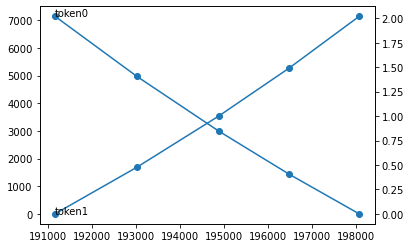

,ticks,amount0,amount1,prices
0,191150.0,7144.356303,0.000000,4998.918171
1,193014.0,4973.338583,0.476718,4148.848570
2,194878.0,2995.507735,1.000000,3443.333910
3,196479.0,1438.775789,1.489752,2934.239077
4,198080.0,0.000000,2.020983,2499.913599


In [29]:
liquidity = pool.functions.liquidity().call()

tick_bottom = 191150
tick_top = 198080

sa = tick_to_price(tick_bottom // 2)
sb = tick_to_price(tick_top // 2)

display(sa, sb)

ax = plt.gca()    # Get current axis
ax2 = ax.twinx()  # make twin axis based on x

ticks = []
amount0 = []
amount1 = []
prices = []

for tick in [tick_bottom, (tick_bottom + current_tick) / 2,  current_tick, (current_tick + tick_top) / 2, tick_top]:
    sp = tick_to_price(tick // 2)
    
    in_tick_amount0 = int(liquidity * (1 / sp - 1 / sb))
    in_tick_amount1 = int(liquidity * (sp - sa))

    ticks.append(tick)
    amount0.append(token0.scaled(in_tick_amount0))
    amount1.append(token1.scaled(in_tick_amount1))
    prices.append(1 / (sp * sp * scale_multiplier))

    display((f'{sa=}, {sb=}, {sp=}, {liquidity=}', f'{in_tick_amount0=}', f'{in_tick_amount1=}'))
    test_1 = (in_tick_amount0 + liquidity / sb) * (in_tick_amount1 + liquidity * sa)
    test_2 = (liquidity * liquidity)
    display(('Test equality:', tick, test_1 / test_2 - 1, test_1 - test_2) )

ax.scatter(ticks, amount0)
ax.plot(ticks, amount0)
ax.text(ticks[0], amount0[0], 'token0')
ax2.scatter(ticks, amount1)
ax2.plot(ticks, amount1)
ax2.text(ticks[0], amount1[0], 'token1')

plt.show()

pd.DataFrame({'ticks': ticks, 'amount0': amount0, 'amount1': amount1, 'prices': prices})


### Per tick liquidity

{191150: 345073104699360, 198080: -345073104699360}

2024684.00 address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' and 2351651526716180.00 address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' remaining in the current tick range


(('token0 balance: ', 2995507735, 2995507575.0, 160.0),
 ('token1 balance: ', 9.999999998703532e+17, 999999999871526563, -1173376.0))

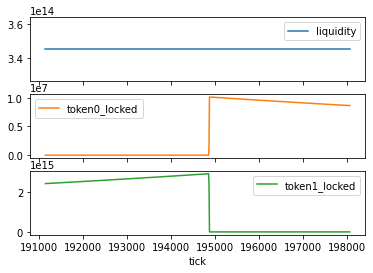

In [30]:
pool_min_tick = 191150
pool_max_tick = 198080

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

display(tick_mapping)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)

df_pool = get_amount_in_ticks(pool, token0, token1, tick_mapping)

display((
    ('token0 balance: ', token0_bal, df_pool.token0_locked.sum(), token0_bal - df_pool.token0_locked.sum()),
    ('token1 balance: ', df_pool.token1_locked.sum(), token1_bal, df_pool.token1_locked.sum() - token1_bal),
))

df_pool.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

In [31]:
display(pool.functions.slot0().call()[1])
df_pool.loc[df_pool.tick.isin([194850, 194860,194870,194880,194890]),:]

194878

,tick,token0,token1,liquidity,token0_locked,token1_locked,token0_scaled,token1_scaled,token0_prop,token1_prop,token0_locked_scaled,token1_locked_scaled,token0_locked_prop,token1_locked_prop
370,194850,10135574.0,2.936773e+15,3.450731e+14,0.0,2.936773e+15,10.135574,0.002937,0.003384,0.002937,0.000000,0.002937,0.000000,0.002937
371,194860,10130508.0,2.938242e+15,3.450731e+14,0.0,2.938242e+15,10.130508,0.002938,0.003382,0.002938,0.000000,0.002938,0.000000,0.002938
372,194870,2024684.0,2.351652e+15,3.450731e+14,2024684.0,2.351652e+15,2.024684,0.002352,0.000676,0.002352,2.024684,0.002352,0.000676,0.002352
373,194880,10120383.0,2.941182e+15,3.450731e+14,10120383.0,0.000000e+00,10.120383,0.002941,0.003379,0.002941,10.120383,0.000000,0.003379,0.000000
374,194890,10115325.0,2.942652e+15,3.450731e+14,10115325.0,0.000000e+00,10.115325,0.002943,0.003377,0.002943,10.115325,0.000000,0.003377,0.000000


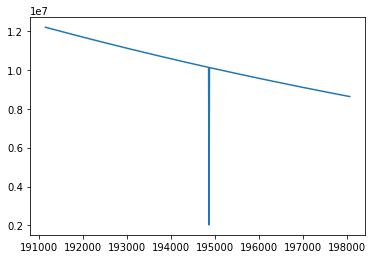

In [32]:
plt.plot(df_pool.tick, df_pool.token0); plt.show()

### 2. After first swap

In [33]:
param = {'chain_id': 1,
 'block_number': 12376891,
 'model_loader_path': [],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context3, model_loader3 = %cmf param
context3.set_current()

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal))

(2875763641, 1034999999871526563)


In [34]:
df_mint_burn_swap_sel = df_mint_burn_swap.query('evt_block_number <= @context3.block_number')
df_mint_burn_swap_sel

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_ticklower,inp_tickupper,inp_amount,inp_amount0,inp_amount1,inp_recipient,inp_liquidity,inp_tick,liquidity,amount0,amount1,pool_liquidity
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,3.450731e+14,2995507735,999999999871526500,NaN,NaN,NaN,345073104699360,2995507735,999999999871526500,345073104699360
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,NaN,NaN,NaN,-119744094,35000000000000000,0xE592427A0AEce92De3Edee1F18E0157C05861564,3.450731e+14,194996.0,NaN,2875763641,1034999999871526500,345073104699360


{191150: 345073104699360, 198080: -345073104699360}

4025347.00 address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' and 1774263639383149.00 address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' remaining in the current tick range


(('token0 balance: ', 2875763641, 2876396955.0, -633314.0),
 ('token1 balance: ',
  1.0347963405215876e+18,
  1034999999871526563,
  -203659349938944.0))

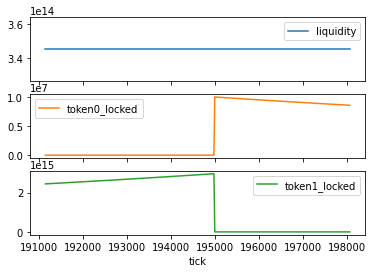

In [35]:
pool_min_tick = df_mint_burn_swap_sel.inp_ticklower.min()
pool_max_tick = df_mint_burn_swap_sel.inp_tickupper.max()

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

display(tick_mapping)

df_pool2 = get_amount_in_ticks(pool, token0, token1, tick_mapping)

display((
    ('token0 balance: ', token0_bal, df_pool2.token0_locked.sum(), token0_bal - df_pool2.token0_locked.sum()),
    ('token1 balance: ', df_pool2.token1_locked.sum(), token1_bal, df_pool2.token1_locked.sum() - token1_bal),
))

df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

### After mint and burn

In [36]:
param = {'chain_id': 1,
 'block_number': 12377266,
 'model_loader_path': [],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context4, model_loader4 = %cmf param
context4.set_current()

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal, current_liquidity))

(887046094, 2703643983514648010, 508154610607382)


In [37]:
df_mint_burn_swap_sel = df_mint_burn_swap.query('evt_block_number <= @context4.block_number')
print(df_mint_burn_swap_sel.liquidity.to_list()[-1])
df_mint_burn_swap_sel

508154610607382


,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_ticklower,inp_tickupper,inp_amount,inp_amount0,inp_amount1,inp_recipient,inp_liquidity,inp_tick,liquidity,amount0,amount1,pool_liquidity
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,3.450731e+14,2995507735,999999999871526500,NaN,NaN,NaN,345073104699360,2995507735,999999999871526500,345073104699360
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,NaN,NaN,NaN,-119744094,35000000000000000,0xE592427A0AEce92De3Edee1F18E0157C05861564,3.450731e+14,194996.0,NaN,2875763641,1034999999871526500,345073104699360
2,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,-3.105658e+14,-2588187276,-931484249884373900,NaN,NaN,NaN,34507310469936,287576365,103515749987152600,34507310469936
3,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150.0,198080.0,0.000000e+00,0,0,NaN,NaN,NaN,34507310469936,287576365,103515749987152600,34507310469936
4,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990.0,195010.0,2.565271e+13,1000000,145737680853531,NaN,NaN,NaN,60160016191517,288576365,103661487668006131,60160016191517
5,12377266,286,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730.0,195460.0,4.479946e+14,598469729,2599999995846641700,NaN,NaN,NaN,508154610607382,887046094,2703661483514647831,508154610607382


In [38]:
pool_min_tick = df_mint_burn_swap_sel.inp_ticklower.min()
pool_max_tick = df_mint_burn_swap_sel.inp_tickupper.max()

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

display(tick_mapping)

df_pool2 = get_amount_in_ticks(pool, token0, token1, tick_mapping)

display((
    ('token0 balance: ', token0_bal, df_pool2.token0_locked.sum(), token0_bal - df_pool2.token0_locked.sum()),
    ('token1 balance: ', df_pool2.token1_locked.sum(), token1_bal, df_pool2.token1_locked.sum() - token1_bal),
))

df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

KeyboardInterrupt: 

In [ ]:
param = {'chain_id': 1,
 'block_number': 12377278,
 'model_loader_path': [],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context5, model_loader5 = %cmf param
context5.set_current()

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal, current_liquidity, current_tick))

In [ ]:
df_mint_burn_swap_sel = df_mint_burn_swap.query('evt_block_number <= @context5.block_number')
print(df_mint_burn_swap_sel.liquidity.to_list()[-2], df_mint_burn_swap_sel.inp_liquidity.to_list()[-1])
df_mint_burn_swap_sel

In [ ]:
param = {'chain_id': 1,
 'block_number': 15269596,
 'model_loader_path': ['../../credmark-models-py/models'],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context6, model_loader6 = %cmf param
context6.set_current()

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal, current_liquidity, current_tick))

In [ ]:
pool_min_tick = min(df_burn_min_max.lower_min.min(), df_mint_min_max.lower_min.min())
pool_max_tick = max(df_burn_min_max.upper_max.max(), df_mint_min_max.upper_max.max())

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

df_pool2 = get_amount_in_ticks(pool, token0, token1, tick_mapping)

display((
    ('token0 balance: ', token0_bal, df_pool2.token0_locked.sum(), token0_bal - df_pool2.token0_locked.sum()),
    ('token1 balance: ', df_pool2.token1_locked.sum(), token1_bal, df_pool2.token1_locked.sum() - token1_bal),
))

df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

In [ ]:
df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked_scaled', 'token1_locked_scaled'], sharex=True, subplots=True, kind='line')
plt.show()

In [ ]:
df_pool2.token1_locked_scaled.sum(), token1.scaled(token1_bal)

In [ ]:
df_pool2.plot(x = 'tick', y = ['liquidity'], figsize=(20,4))
plt.vlines(x=current_tick, ymin=0, ymax=df_pool2.liquidity.max(), linestyles='dashed', colors='red')
plt.show()

df_pool2.query('(tick > 170000) & (tick < 220000)').plot(x = 'tick', y = ['liquidity'], figsize=(20,4))
plt.vlines(x=current_tick, ymin=0, ymax=1.75e19, linestyles='dashed', colors='red')
plt.show()

In [ ]:
ax = plt.gca()    # Get current axis
ax2 = ax.twinx()  # make twin axis based on x

df_pool2.query('(tick > @current_tick-@tick_spacing*10) & (tick < 220000)').plot(x = 'tick', y = ['token0_locked_scaled'], figsize=(20,4), ax=ax)
df_pool2.query('(tick < @current_tick-@tick_spacing*10) & (tick > 170000)').plot(x = 'tick', y = ['token1_locked_scaled'], figsize=(20,4), ax=ax2, color='green')
ax.vlines(x=current_tick, ymin=0, ymax=df_pool2.token0_locked_scaled.max(), linestyles='dashed', colors='red')
plt.show()

In [ ]:
pa = 2022
pb = 1358

p_a = (1 / pa / scale_multiplier)
p_b = (1 / pb / scale_multiplier)

tick_a = math.log(p_a) / math.log(1.0001)
tick_b = math.log(p_b) / math.log(1.0001)

ax = plt.gca()    # Get current axis
ax2 = ax.twinx()  # make twin axis based on x

df_pool2_sel = df_pool2.query('(tick > @tick_a) & (tick < @tick_b)')
df_pool2_sel

df_pool2_sel.plot(x = 'tick', y = ['token0_locked_scaled'], figsize=(20,4), ax=ax)
df_pool2_sel.plot(x = 'tick', y = ['token1_locked_scaled'], figsize=(20,4), ax=ax2, color='green')
ax.vlines(x=current_tick, ymin=0, ymax=df_pool2_sel.token0_locked_scaled.max(), linestyles='dashed', colors='red')
plt.show()

![UniswapV3 USDC-WETH-POOL]('pool_liquidity_usdc_weth.png')

In [ ]:
df_pool2.query('(tick > @tick_a) & (tick < @tick_b)')